## Load libraries

In [1]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from vae_utils import VAEUtils
import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

RDKit WARNING: [23:25:30] Enabling RDKit 2019.09.2 jupyter extensions
Using TensorFlow backend.


# Load a model

In [2]:
vae = VAEUtils(directory='/Users/user/Desktop/MyGitHub/chemical_vae/examples/zinc_properties')

From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:442: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3543: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:112: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1205: calling reduce_prod_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2888: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will 

Using standarized functions? True
Standarization: estimating mu and std values ...done!


# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r

In [3]:
#Caffiene
smiles_1 = mu.canon_smiles('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')
#Nicotine 
smiles_2= mu.canon_smiles('CN1CCCC1C2=CN=CC=C2')

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

X_2 = vae.smiles_to_hot(smiles_2,canonize_smiles=True)
z_2 = vae.encode(X_2)
X_r2= vae.decode(z_2)


print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))
print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

print('{:20s} : {}'.format('Input',smiles_2))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r2,strip=True)[0]))
print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_2.shape, np.linalg.norm(z_2)))

Input                : Cn1c(=O)c2c(ncn2C)n(C)c1=O
Reconstruction       : Cn1c(=O)c2c(ncn2C)n(C)c1=O)c1
Z representation     : (1, 196) with norm 13.032
Input                : CN1CCCC1c1cccnc1
Reconstruction       : CN1CCSC)c1cccnc1
Z representation     : (1, 196) with norm 12.490


## Load property predictor

In [23]:
print('Properties (qed,SAS,logP):')

y_1 = vae.predict_prop_Z(z_1)[0]
y_2 = vae.predict_prop_Z(z_2)[0]
print('{:20s} : (QED: {:.3f}, SAS: {:.3f}, logP :{:.3f})'.format('Predicted properties of caffiene',y_1[0], y_1[1], y_1[2]))
print('{:20s} : (QED: {:.3f}, SAS: {:.3f}, logP :{:.3f})'.format('Predicted properties of nicotine',y_2[0], y_2[1], y_2[2]))
# print(y_2)

Properties (qed,SAS,logP):
Predicted properties of caffiene : (QED: 0.654, SAS: 2.822, logP :-0.965)
Predicted properties of nicotine : (QED: 0.724, SAS: 2.284, logP :1.573)


## Decode several attempts
VAE are probabilistic

1
Searching molecules randomly sampled from 10.00 std (z-distance) from the point
2
Found 17 unique mols, out of 862
SMILES
 0     Cn1c(=O)c2c(ncn2C)n(C)c1=O
1     Cn1c(=O)c2c(ncn2C)n(C)C1=O
2     Cn1c(=O)c2c(ncn2C)N(C)c1=O
3     Cn1C(=O)c2c(ncn2C)n(C)c1=O
4     Cn1c(=O)c2c(ncn2S)n(C)c1=O
5     Cn1c(=O)c2c(nnn2C)n(C)c1=O
6     Cn1c(=O)c2c(cnn2C)n(C)c1=O
7     Cn1c(=O)c2c(ncn2F)n(C)C1=O
8     Cn1c(=O)c2c(ncn2F)n(C)c1=O
9     Cn1c(=O)c2c(cnn2F)n(C)c1=O
10    Cn1c(=O)c2c(ccn2C)n(C)c1=O
11    Cn1c(=O)c2c(ncn2I)n(C)c1=O
12    Cn1c(=O)c2c(ccn2F)n(C)c1=O
13    Cn1c(=O)c2c(ncnc2)n(C)c1=O
14    Cn1c(=O)c2c(cnnc2)n(C)c1=O
15    Cn1c(=O)c2c(ncn2)cn(C)c1=O
16    Cn1c(=O)c2c(ncn2)nn(C)c1=O
Name: smiles, dtype: object


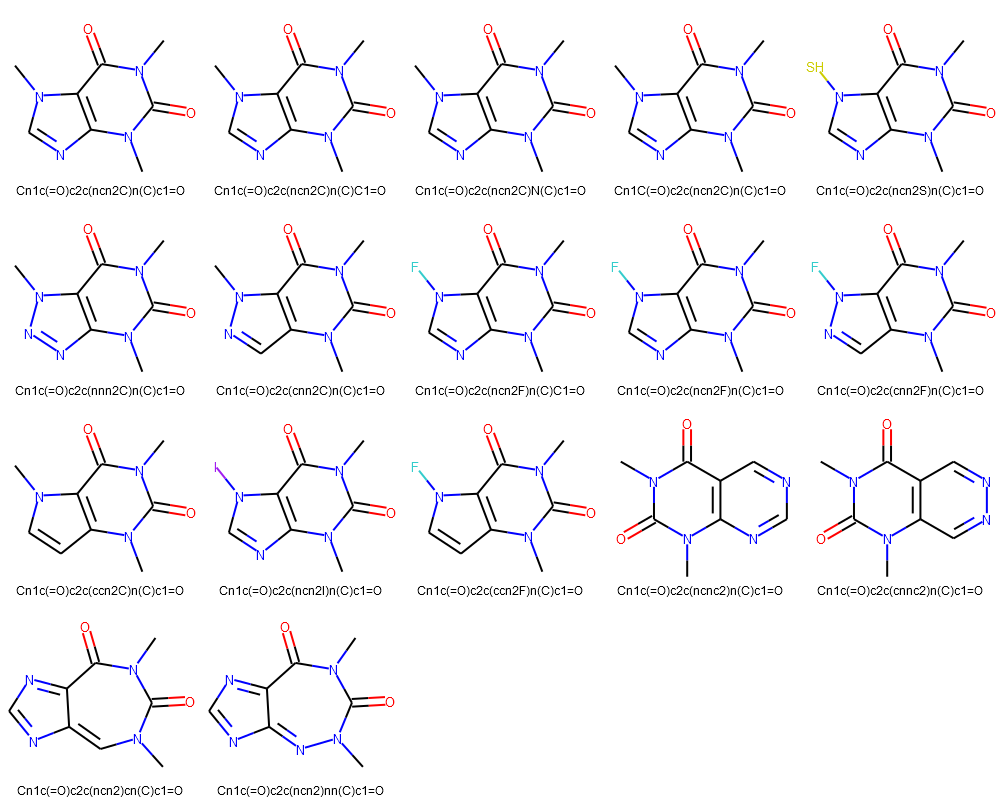

                        smiles   distance  count  frequency  \
0   Cn1c(=O)c2c(ncn2C)n(C)c1=O   0.000008    587   0.680974   
1   Cn1c(=O)c2c(ncn2C)n(C)C1=O   0.000008      2   0.002320   
2   Cn1c(=O)c2c(ncn2C)N(C)c1=O   0.000008      2   0.002320   
3   Cn1C(=O)c2c(ncn2C)n(C)c1=O   0.000008      1   0.001160   
4   Cn1c(=O)c2c(ncn2S)n(C)c1=O   2.527831      1   0.001160   
5   Cn1c(=O)c2c(nnn2C)n(C)c1=O   3.060284      2   0.002320   
6   Cn1c(=O)c2c(cnn2C)n(C)c1=O   3.157399     18   0.020882   
7   Cn1c(=O)c2c(ncn2F)n(C)C1=O   3.282058      1   0.001160   
8   Cn1c(=O)c2c(ncn2F)n(C)c1=O   3.282058    155   0.179814   
9   Cn1c(=O)c2c(cnn2F)n(C)c1=O   3.469211      3   0.003480   
10  Cn1c(=O)c2c(ccn2C)n(C)c1=O   4.118289      5   0.005800   
11  Cn1c(=O)c2c(ncn2I)n(C)c1=O   4.255864      1   0.001160   
12  Cn1c(=O)c2c(ccn2F)n(C)c1=O   5.220474      1   0.001160   
13  Cn1c(=O)c2c(ncnc2)n(C)c1=O  11.408975     70   0.081206   
14  Cn1c(=O)c2c(cnnc2)n(C)c1=O  11.837468      4   0.00

In [14]:
noise=10
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_1,decode_attempts=1000,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
print(df)


Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 5 unique mols, out of 7
SMILES
 0    CN1CCSC1c2cccnc2
1    CN1CCSC1c1cccnc1
2    CN1CCSC2c1cccnc2
3    CN1CCC(C)ccccnc1
4    OC1C#CC2c1cccnc2
Name: smiles, dtype: object


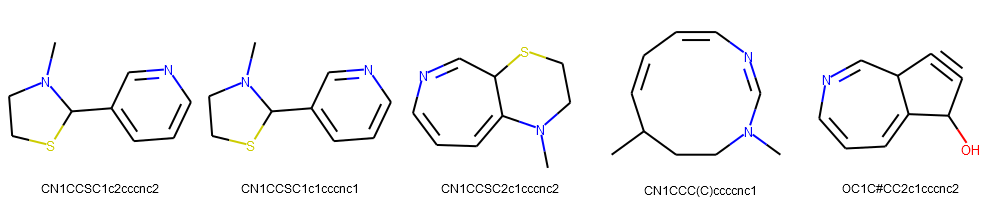

,smiles,distance,count,frequency,mol
0,CN1CCSC1c2cccnc2,2.413746,1,0.142857,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CN1CCSC1c1cccnc1,2.413746,2,0.285714,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CN1CCSC2c1cccnc2,11.374433,1,0.142857,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CN1CCC(C)ccccnc1,11.760579,2,0.285714,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,OC1C#CC2c1cccnc2,13.709982,1,0.142857,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [7]:
noise=11.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_2,decode_attempts=100,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

## Interpolate using Slerp


[0.7323833  2.1095202  0.77989966]
Reconstruction       : N1=CSC(c2ccccnc2
Searching molecules randomly sampled from 1.00 std (z-distance) from the point
Found 101 unique mols, out of 639
SMILES
 0             CN1CCCN1c1cccnc1
1             CN1CCSC1c2cccnc2
2             Fn1CCSC1c2cccnc2
3         CN1CCC(c2ccccn2)c1=O
4         Cn1CCSC(c2cccnc2)C1O
5             CN1CCSC1c2ccncc2
6         Cn1CCC(c2cccnc2)c1=O
7             ON1CCC1-c2cccnc2
8         Cn1CCC(-c2cccnc2)C1O
9             Oc1CCSC1c2ccncc2
10        Cn1CCC(c2cccnc2)cc1O
11             ON1CCSc2c1ccnc2
12            Cn1CCCN2c1ccncc2
13            CN1CCCN2c1ccncc2
14            CN1CCOC2c1ccncc2
15            N1=CCCN2c1cccnc2
16            OC1CCCN2c1ccncc2
17            NC1CCCN2c1ccncc2
18            ON1CCCN2c1ccncc2
19            OC1CCOC2c1ccncc2
20            CN1CCC2-c1ccncc2
21            C1=CCCN2c1cccnc2
22            CN1CCC2-c1cccnc2
23            Cn1CCCN2c1cccnc2
24            CN1CCCn2c1cccnc2
25            Cn1CCCn2c1cccnc

C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


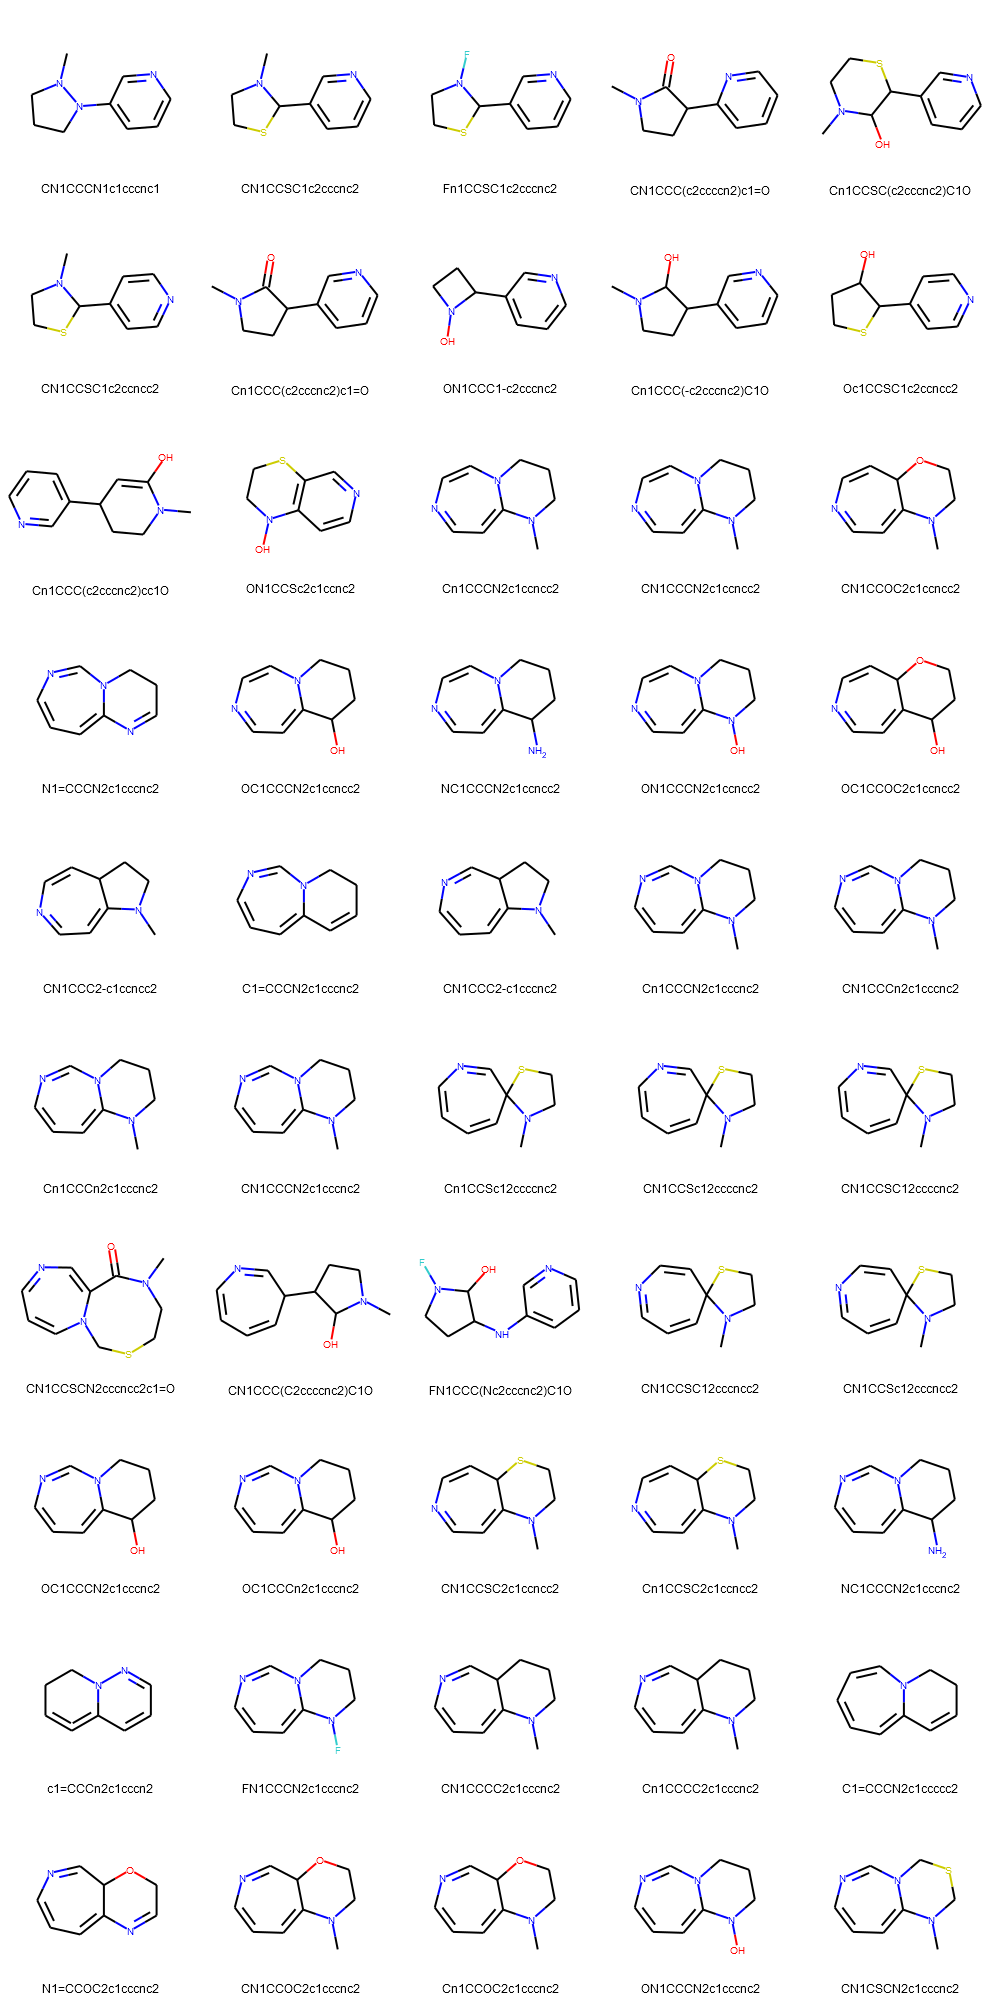

,smiles,distance,count,frequency,mol
0,CN1CCCN1c1cccnc1,8.585196,1,0.001565,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CN1CCSC1c2cccnc2,8.694416,2,0.003130,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,Fn1CCSC1c2cccnc2,8.914779,1,0.001565,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CN1CCC(c2ccccn2)c1=O,9.020512,1,0.001565,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,Cn1CCSC(c2cccnc2)C1O,9.052069,1,0.001565,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [96]:
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy.linalg import norm

def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), np.transpose(high/norm(high))), -1, 1))
    so = sin(omega)
    if so == 0:
    # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

m1=slerp((z_2[0]-z_1[0])/2,z_2,z_1)
y_1 = vae.predict_prop_Z(m1)[0]
print(y_1)

X_r3= vae.decode(m1)


print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r3,strip=True)[0]))

noise=1
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( m1,decode_attempts=10000,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()


In [21]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000,return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data).reset_index()
prop_df['smiles']=smiles
prop_df.head()

,index,logP,qed,SAS,smiles
0,247631,2.60196,0.866897,4.195934,Cc1ccc([N-]S(=O)(=O)c2c(C)nn(C(C)(C)C)c2C)c(C[...
1,108778,2.31450,0.843380,3.766386,Cn1ncc(C(=O)[C@H]2CCOC3(CCCCC3)C2)c1N
2,201477,3.00670,0.796352,2.220869,CC(C)CN(C(=O)CS(=O)(=O)c1ccc(Cl)cc1)C(C)C
3,128169,2.39072,0.670367,2.863231,C#CCn1/c(=N\C(=O)c2cc(C)on2)sc2c(OC)ccc(OC)c21
4,192292,1.85210,0.896191,3.818619,COc1cccc(CN2CC3(CCN(Cc4[nH]cc[nH+]4)CC3)CC2=O)c1


Perform a PCA projection and color the points based on a property

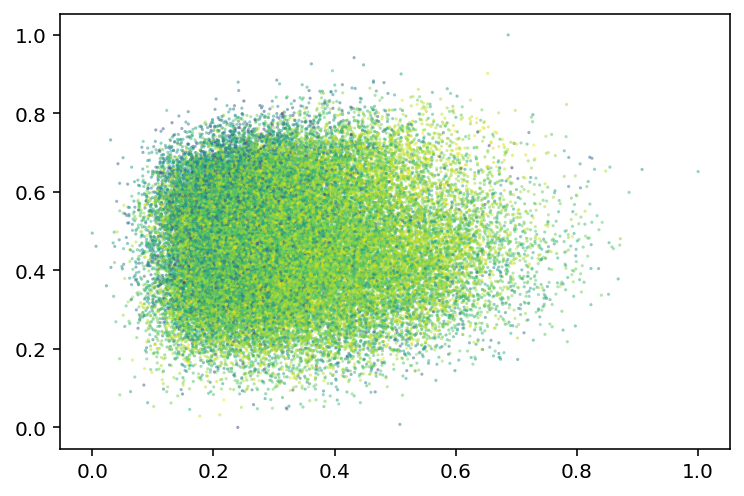

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

compare with t-SNE, will take some time

In [16]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)

f = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

KeyboardInterrupt: 